There is a central difficulty in processing geospatial data, which is that the earth is round and our screens are flat. To "fix" this we use map projections, which are [always a tradeoff](https://xkcd.com/977/).

If we want to do meaningful machine learning on geospatial data, we'll often need to transform it to something rectangular, as that allows us to do 2D convolutions and other magic. ([Spherical](https://medium.com/@samramasinghe/spherical-convolution-a-theoretical-walk-through-98e98ee64655) and [graph convolutions](https://github.com/rusty1s/pytorch_geometric) might be interesting as well.)

To choose a good map projection, we need to know that a projection can have different [properties](https://map-projections.net/properties.php):
- Conformal: Draw a 90° cross on the earth and in your map it will always be at 90°
- Equal-area: The area of any piece of land is the same on earth as on your map
- Equidistant: Only interesting if you want to measure distance from a point or line

A map cannot be conformal and equal-area at the same time. A map can be equidistant and equal-area. Most maps are "compromise" maps where they have none of these properties but try to make a good compromise for a certain usecase.

If we are doing convolutions on geospatial data, e.g. [recognizing hurricanes](https://progearthplanetsci.springeropen.com/articles/10.1186/s40645-018-0245-y), we might want to use a conformal projection so that local shapes like the eye of a hurricane are mostly correct. If we limit the projection to a small area, we can have a quite low-distortion view of the earth. For example, the [mercator](https://map-projections.net/compare.php?p1=lambert-conformal-conic&p2=mercator-84&w=-1&sps=1) projection seems suitable, especially its transverse variant (as used in the UTM system), as that works better for higher latitudes. A TM projection over central europe can be defined in terms of proj4 string as follows:

```python
# See https://proj.org/operations/projections/tmerc.html
>>> from pyproj import CRS
# Central meridian is at 15deg East
>>> crs_tmerc = CRS.from_proj4("+proj=tmerc +lon_0=15")
```

We can use this projection to calculate the new grid in terms of old coordinates, and do the resampling. This is more complicated than resampling a simple image, as we don't take e.g. every 5th pixel (simple strided indexing) but are reprojecting to a completely different, warped space. I'm especially interested in how to do this interpolation in a fast way, and what the differences in quality are between various methods.

<!-- TEASER_END -->

We use the same [ERA5 temperature dataset](https://the-fonz.gitlab.io/posts/array-databases/#Downloading-ERA5-hourly-temperature-data) as in the previous article, so let's load that first.

In [1]:
# Using this Python version...
!python --version
# ... and these libraries. Copy-paste and run in another cell to install these versions into your environment
!echo "!pip install" $(pip freeze | grep -E "(numpy|numba|matplotlib|pyresample|pandas=|pyproj|dask|distributed|scipy)" | tr '\n' ' ')

Python 3.8.1
!pip install dask==2.12.0 distributed==2.12.0 matplotlib==3.2.0 numba==0.48.0 numpy==1.18.1 pandas==1.0.2 pyproj==2.5.0 pyresample==1.14.0 scipy==1.4.1


In [2]:
import re
import warnings
from timeit import timeit

import numpy as np
from numba import njit
import xarray as xr
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.filters import gaussian_filter
from pyresample.geometry import AreaDefinition
from pyresample.image import ImageContainerNearest, ImageContainerQuick, ImageContainer
from pyresample import utils
# Ignore this annoying proj4 warning that pops up during use of pyresample
warnings.filterwarnings("ignore", "You will likely lose important projection information when converting to a PROJ string")

FIGSIZE = (14, 7)

In [3]:
# See previous article for instructions on downloading this dataset
# We only chunk in time dimension to keep the spatial dimension together
ds = xr.open_dataset("data/era5-2018-t2m-hourly.nc", chunks={"time": "auto"})

# Put Europe central and make sure coords are monotonically increasing
ds = ds.reindex(dict(
    longitude=np.roll(ds.longitude.values, len(ds.longitude)//2),
    latitude=sorted(ds.latitude.values)
))
ds.coords["longitude"] = ds.longitude.where(ds.longitude < 180, ds.longitude - 360)

ds.t2m.data

dask.array<getitem, shape=(8760, 721, 1440), dtype=float32, chunksize=(30, 721, 1440), chunktype=numpy.ndarray>

## Defining our new grid

ERA5 is delivered on a regular lat/lon grid ("unprojected") with spacing of 0.25 degrees. Let's define a rectangular area in our new projection, give it an appropriate resolution, and plot it on our dataset as points.

In [4]:
crs_tmerc = CRS.from_proj4("+proj=tmerc +lon_0=15")
crs_tmerc

<Projected CRS: +proj=tmerc +lon_0=15 +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# https://pyproj4.github.io/pyproj/stable/examples.html#converting-between-geographic-and-projection-coordinates-within-one-datum
transformer = Transformer.from_crs(crs_tmerc.geodetic_crs, crs_tmerc, always_xy=True)

# We keep the extent symmetric around the 15* center so we can easily calculate the extent in the unprojected space
lonmin = 0
latmin = 30
lonmax = 30
latmax = 60

# We need to calculate x min/max at the lower edge of the domain, as there one degree longitude presents the largest distance in transverse mercator
# This is to get a nice square area in our new space that covers *at least* the domain we've specified
x_min, y_min = transformer.transform(lonmin, latmin)
x_max, _ = transformer.transform(lonmax, latmin)
_, y_max = transformer.transform(lonmin, latmax)

def get_grids(x_min, x_max, y_min, y_max, resolution_m):
    "Given boundaries in transverse mercator projection, make 1D x/y, 2D X/Y and 2D lon/lat grids"    
    x = np.arange(x_min, x_max, resolution_m)
    y = np.arange(y_min, y_max, resolution_m)
    
    X, Y = np.meshgrid(x,y)
    # pyproj enables us to do a reverse transform using the same transformer
    return (x, y), (X, Y), np.stack(transformer.transform(X, Y, direction="INVERSE"))

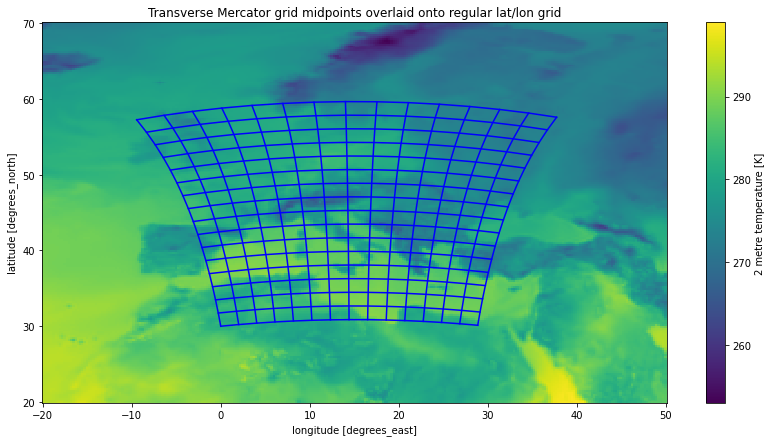

In [6]:
ds.t2m.isel(time=0).sel(longitude=slice(-20, 50), latitude=slice(20, 70)).plot(figsize=FIGSIZE)
# Use higher spacing for nicer visualization without too many lines
_, _, pts = get_grids(x_min, x_max, y_min, y_max, 2E5)

for i in range(pts.shape[1]):
    plt.plot(*pts[:,i].reshape((2,-1)), 'b-')
for i in range(pts.shape[2]):
    plt.plot(*pts[:,:,i].reshape((2,-1)), 'b-')

# Note that in this visualization we have indicated the pixel midpoints, not the actual borders of the pixels
plt.title("Transverse Mercator grid midpoints overlaid onto regular lat/lon grid");

## Interpolating nearest-neighbor style with pyresample

Now that we have defined a grid we want to transform to, we can do the interpolation itself. We'll first attempt to do this with [pyresample](https://pyresample.readthedocs.io/en/latest/), which offers us nearest-neighbor interpolation.

In [7]:
# Resolution of input data is .25deg, so half pixel is .125deg wide
half_pix = .25/2

# This AreaDefinition is specific to pyresample, and lets it compute the required properties
era5_areadef = AreaDefinition(
    area_id="regular_latlon",
    description="Regular lat/lon grid of ERA5",
    # This argument is being deprecated
    proj_id=None,
    # proj4 string
    projection="epsg:4326",
    width=len(ds.longitude),
    height=len(ds.latitude),
    # Taking size of "pixel" into account according to 
    # https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference
    area_extent=(
        ds.longitude.values.min() - half_pix,
        ds.latitude.values.min() - half_pix,
        ds.longitude.values.max() + half_pix,
        ds.latitude.values.max() + half_pix
    )
)

era5_areadef

Area ID: regular_latlon
Description: Regular lat/lon grid of ERA5
Projection: {'datum': 'WGS84', 'no_defs': 'None', 'proj': 'longlat', 'type': 'crs'}
Number of columns: 1440
Number of rows: 721
Area extent: (-180.125, -90.125, 179.875, 90.125)

In [8]:
# Now we create a grid with a resolution of 10km
resolution_m = 10000
(x, y), (X, Y), grid_lonlat = get_grids(x_min, x_max, y_min, y_max, resolution_m)

def get_tm_areadef(x, y, resolution_m):
    "Get transverse mercator pyresample.geometry.AreaDefinition"
    tm_half_pix = resolution_m / 2
    return AreaDefinition(
        area_id="tm",
        description="Transverse Mercator grid over central europe",
        proj_id=None,
        projection="+proj=tmerc +lon_0=15",
        width=len(x),
        height=len(y),
        area_extent=(
            x_min - tm_half_pix,
            y_min - tm_half_pix,
            x_max + tm_half_pix,
            y_max + tm_half_pix
        )
    )

tm_areadef = get_tm_areadef(x, y, resolution_m)
tm_areadef

Area ID: tm
Description: Transverse Mercator grid over central europe
Projection: {'datum': 'WGS84', 'k': '1', 'lat_0': '0', 'lon_0': '15', 'no_defs': 'None', 'proj': 'tmerc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 292
Number of rows: 334
Area extent: (-1460590.7389, 3411780.5622, 1460590.7389, 6754222.0128)

In [9]:
# NOTE: pyresample expects image data to have its origin in the upper left corner,
# while xarray uses origin in lower left corner convention
c = ImageContainerNearest(
    ds.t2m.isel(time=0).values[::-1],
    era5_areadef,
    radius_of_influence=20000
)
%timeit c.resample(tm_areadef)
m = c.resample(tm_areadef)

92.1 ms ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


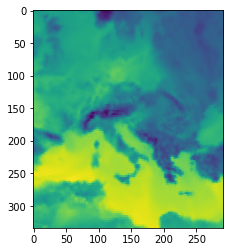

In [10]:
plt.imshow(m.image_data);

Cool! Our first resampled image!

It is quite slow but luckily not representative, as it's calculating the nearest neighbors again for every run. Instead, we can save this matrix of indices (see [pyresample docs](https://pyresample.readthedocs.io/en/latest/preproc.html)).

In [11]:
linesample_arrays = np.stack(utils.generate_nearest_neighbour_linesample_arrays(era5_areadef, tm_areadef, radius_of_influence=20000))
# Show a few lines
linesample_arrays[:,:3,:10]

array([[[127, 127, 126, 126, 126, 126, 126, 126, 126, 125],
        [127, 127, 127, 127, 126, 126, 126, 126, 126, 126],
        [127, 127, 127, 127, 127, 127, 127, 126, 126, 126]],

       [[679, 680, 680, 681, 682, 682, 683, 683, 684, 685],
        [679, 680, 681, 681, 682, 682, 683, 684, 684, 685],
        [680, 680, 681, 681, 682, 683, 683, 684, 685, 685]]], dtype=uint16)

In [12]:
c = ImageContainer(ds.t2m.isel(time=0).values[::-1], era5_areadef)
%timeit c.get_array_from_linesample(*linesample_arrays)

1.21 ms ± 58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Woah! That's quite a lot faster. We might be able to do this even faster though, as in the [pyresample source code](https://github.com/pytroll/pyresample/blob/ef22d210b9b150643e7e1a230495fd4229809d29/pyresample/grid.py#L33) we can see that quite a bit of extra checking is being done which is superfluous if your grid does not have invalid indices.

In [13]:
v = ds.t2m.isel(time=0).values[::-1]

%timeit v[linesample_arrays[0], linesample_arrays[1]]

assert (c.get_array_from_linesample(*linesample_arrays) ==
        v[linesample_arrays[0], linesample_arrays[1]]).all(), "Output is not exactly the same"

549 µs ± 9.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Nice! Another big improvement. Circumventing all the checks we can speed it up 2.5x, while the output is exactly the same.

## Obsessed with speed: fast indexing

Let's get obsessive with speed for a bit, and focus on the quality of the projection later. We can index in many ways, for example by flattening the array first, which might yield some improvement. We can even just-in-time-compile using [numba](http://numba.pydata.org/). Let's try a few different things.

In [14]:
# Prepare flattened arrays for 1D indexing
idx = linesample_arrays[0] * ds.t2m.shape[2] + linesample_arrays[1]
v_flat = v.ravel()

In [15]:
# All algorithms to take index (nearest-neighbor usually)
@njit
def nb_simple(x, idx_row, idx_col):
    "Loop over the index array and pick values from target array"
    out = np.zeros(idx_row.shape)
    
    for i in range(idx_row.shape[0]):
        for j in range(idx_row.shape[1]):
            r = idx_row[i,j]
            c = idx_col[i,j]
            out[i,j] = x[r,c]
    
    return out

@njit
def nb_simple_1d(x, idx, out_shape):
    "Pass a fully flattened array and do a 1D loop"
    out = np.zeros(idx.shape)
    
    for i in range(idx.shape[0]):
        out[i] = x[idx[i]]
    
    return out.reshape(out_shape)

@njit
def fancy(x, idx, out_shape):
    "Use the ndarray.take() method to pick indexes in 1D"
    x.take(idx).reshape(out_shape)

@njit
def fancycache(x, idx_row, idx_col):
    "Try very fancy method designed to keep L1 cache filled"
    out_rows = idx_row.shape[0] - (32 - idx_row.shape[0] % 32)
    out_cols = idx_row.shape[1] - (32 - idx_row.shape[1] % 32)
    out = np.zeros((out_rows, out_cols))

    for i_block_offset in range(0, out_rows-32, 32):
        for j_block_offset in range(0, out_cols-32, 32):
            # Blocks
            out_block = out[i_block_offset:i_block_offset+32, j_block_offset:j_block_offset+32]
            idx_row_block = idx_row[i_block_offset:i_block_offset+32, j_block_offset:j_block_offset+32]
            idx_col_block = idx_col[i_block_offset:i_block_offset+32, j_block_offset:j_block_offset+32]
            for i in range(32):
                for j in range(32):
                    r = idx_row_block[i,j]
                    c = idx_col_block[i,j]
                    out_block[i,j] = x[r,c]
    
    return out

# Run at least once so they are compiled by numba
nb_simple(v, linesample_arrays[0], linesample_arrays[1])
nb_simple_1d(v_flat, idx, linesample_arrays[0].shape)
fancy(v_flat, idx, linesample_arrays[0].shape)
fancycache(v, linesample_arrays[0], linesample_arrays[1]);

In [16]:
conf = [
    ("1D plain numpy", "v_flat[idx]", 1E4),
    ("2D raw pyresample", "c.get_array_from_linesample(*linesample_arrays)", 1E3),
    ("2D numba looping", "nb_simple(v, linesample_arrays[0], linesample_arrays[1])", 1E4),
    ("1D numba looping", "nb_simple_1d(v_flat, idx, linesample_arrays[0].shape)", 1E4),
    ("1D pure numpy .take()", "v_flat.take(idx).reshape(linesample_arrays[0].shape)", 1E4),
    ("1D numba-compiled .take(idx)", "fancy(v_flat, idx, linesample_arrays[0].shape)", 1E4),
    ("2D block iteration", "fancycache(v, linesample_arrays[0], linesample_arrays[1])", 1E4),
]

times = []
# Execute every statement REPS times
for name, code, reps in conf:
    t = (
        name + ", " + re.sub("\(.+\)", "(...)", code),
        timeit(code, number=int(reps), globals=globals()),
        reps
    )
    times.append(t)

# Print nicely formatted summary of execution times
maxlen = max(len(s[0]) for s in times) + 5
# Take numpy as reference time
maxtime = times[0][1]
print(f"Time per execution:")
for t in times:
    print(f"{t[0]:{maxlen}s} {t[1]/t[2]*1E6:>5.1f}us   {maxtime/t[1]:.2f}x")


Time per execution:
1D plain numpy, v_flat[idx]                              218.7us   1.00x
2D raw pyresample, c.get_array_from_linesample(...)      1143.0us   1.91x
2D numba looping, nb_simple(...)                         132.7us   1.65x
1D numba looping, nb_simple_1d(...)                      158.3us   1.38x
1D pure numpy .take(), v_flat.take(...)                  145.4us   1.50x
1D numba-compiled .take(idx), fancy(...)                  66.5us   3.29x
2D block iteration, fancycache(...)                      127.7us   1.71x


Cool! We have been able to speed the indexing up quite a bit by using numba-compiled 1D `.take(idx)` approach. The speedup is not that meaningful though, as it's in the same order of magnitude and data loading will probably take much longer. Interesting is that our fancy "L1 cache-optimized" attempt does not seem to work at all, which makes sense as this is indexing and [numexpr](https://numexpr.readthedocs.io/en/latest/intro.html), which uses the "block" technique successfully, operates over arrays of constant size. A quick test proves that it also doesn't work for large arrays, it would probably require much more effort to provide any kind of benefit. Still, it was fun to be obsessed with speed for a bit.

## Quality of interpolations of different sizes

This nearest-neighbor interpolation is nice, but we have many more interpolation techniques that might yield different results.

When interpolating satellite image A to grid B we basically have 3 situations:
- A < B: Resolution of A is smaller than B. We are upsampling and might want to use linear/bicubic interpolation to make the resulting image a bit smoother.
- A ~ B: Resolution is approximately the same. We might want to just take the nearest neighbor.
- A > B: Resolution of B is much smaller, we are downsampling, we might want to average over a larger area to get the most "correct" image.

Please note that I am no expert in this, it's just what I would guesstimate based on common sense. There are many techniques like this used in computer graphics.

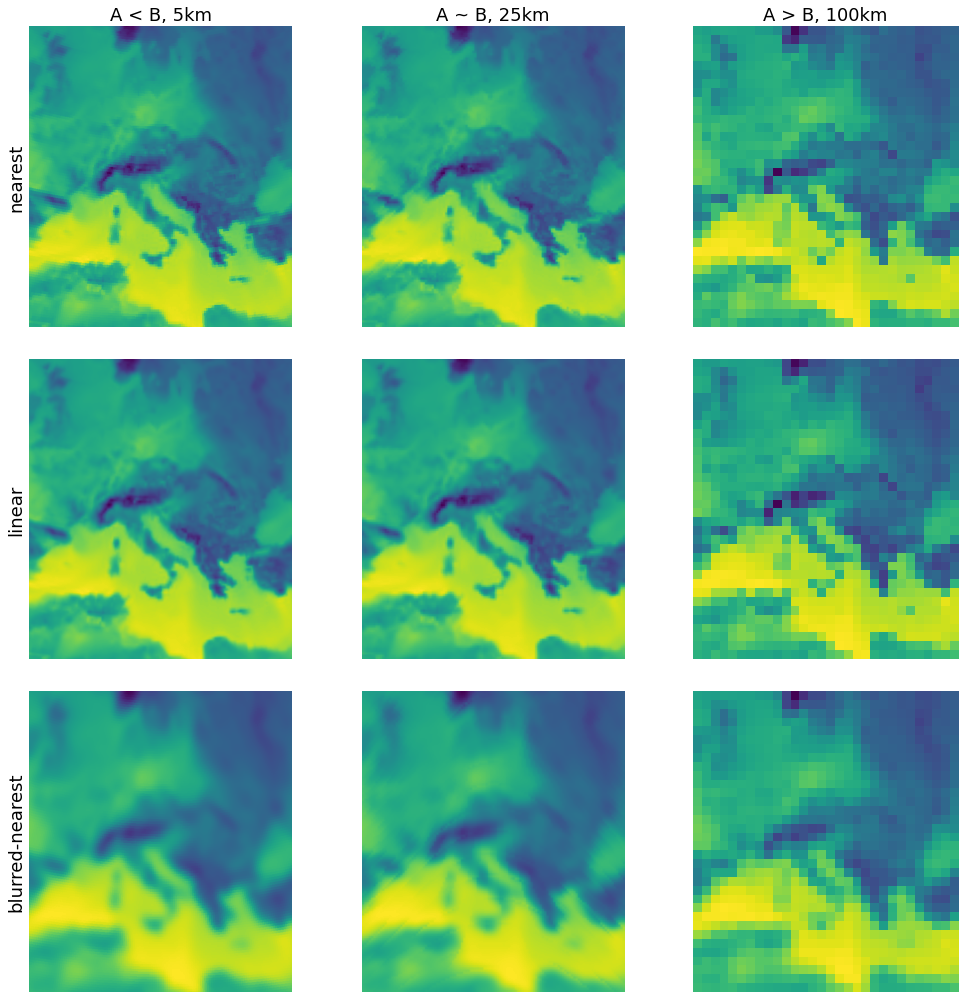

In [17]:
# 5km, 25km (~native) and 100km resolutions
resolutions = [
    ("A < B", 5000),
    ("A ~ B", 25000),
    ("A > B", 100000)
]


def nearest(data, x, y, X, Y, grid_lonlats, resolution_m):
    "Interpolate by finding nearest point"
    tm_areadef = get_tm_areadef(x, y, resolution_m)
    c = ImageContainerNearest(
        data,
        era5_areadef,
        radius_of_influence=20000
    )
    return c.resample(tm_areadef).image_data


def linear(data, x, y, X, Y, grid_lonlats, resolution_m):
    "Interpolate linearly between closest points"
    # This function does not triangulate, just assumes it's a regular grid
    interpolator = RegularGridInterpolator((ds.longitude.values, ds.latitude.values), data[::-1].T)

    return interpolator(grid_lonlats.reshape((2, -1)).T).reshape(X.shape)[::-1]


def blurred(data, x, y, X, Y, grid_lonlats, resolution_m, blur_size=2):
    "First distribute information spatially by blurring and then take nearest point"
    data = gaussian_filter(data, sigma=blur_size)

    return nearest(data, x, y, X, Y, grid_lonlats, resolution_m)


interpolators = [
    ("nearest", nearest),
    ("linear", linear),
    ("blurred-nearest", blurred)
]

def plot_experiments(data):
    fig, axes = plt.subplots(len(interpolators), len(resolutions), figsize=(FIGSIZE[0], FIGSIZE[0]))
    plt.tight_layout()

    for j, (res_name, res) in enumerate(resolutions):
        # Set title above plot
        axes[0,j].set_title(f"{res_name}, {res/1E3:.0f}km", fontsize=18)
        (x,y), (X,Y), grid_lonlats = get_grids(x_min, x_max, y_min, y_max, res)
        for i, (name, interp) in enumerate(interpolators):
            if not j:
                plt.text(-.05, 0.5, name, horizontalalignment='center',
                         verticalalignment='center', transform=axes[i,j].transAxes, rotation=90, fontsize=18)
            # Remove black border, ticks, tick labels
            axes[i,j].set_axis_off()
            axes[i,j].imshow(interp(data, x, y, X, Y, grid_lonlats, res))

plot_experiments(ds.t2m.isel(time=0).values[::-1])

Now that we have these different situations we can compare them properly:

|                | A < B         | A ~ B          | A > B  |
|----------------| --------------|:--------------:| ------:|
|*nearest*         | slightly blocky | looks ok, some artifacts  | noisy |
|*linear*          | smooth                    | looks ok                  | noisy |
|*blurred-nearest* | blurry and a bit blocky   | better visible artifacts  | smoother |

In the first case, it seems that the linear interpolation is smoothest, as it actually interpolates between pixel values instead of taking the nearest. It's kind of like anti-aliasing. Another option that might work even better is bicubic interpolation.

The second case shows some [moiré interference patterns](https://en.wikipedia.org/wiki/Moir%C3%A9_pattern) for nearest-neighbor interpolation. The linear method does not have this, as it picks values in between the pixels.

In the third case, we can see that distributing the spatial information (low-pass filter) before resampling gives us a (presumably) more accurate result, as it takes a bit more of the environment around every sample point into account while the other two methods only sample the value at one point. Another way to do this is to use a box filter which takes all pixels falling into a certain "grid box" into account, but I could not find an implementation of this in the scipy ecosystem.

We can see these differences even much better if we use sharper lines.

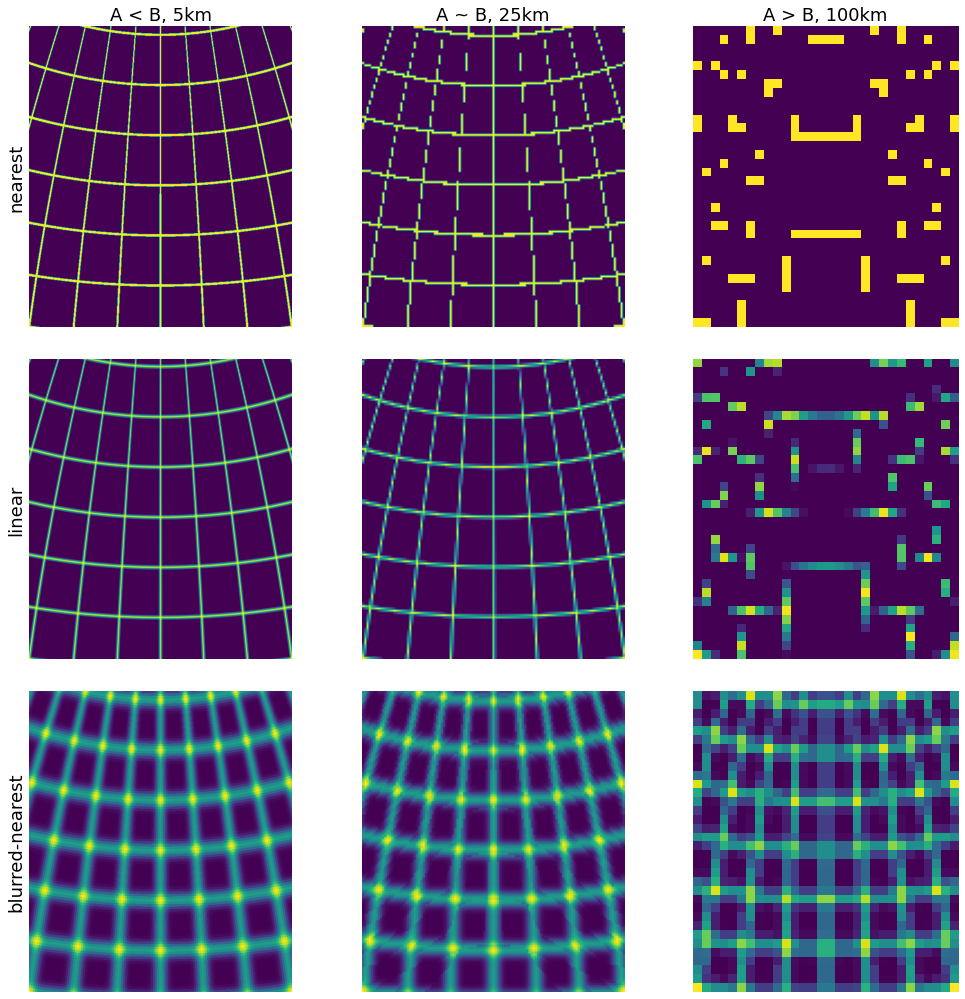

In [18]:
data = np.zeros_like(ds.t2m.isel(time=0).values[::-1])

# Create simple stripe pattern
for i in range(data.shape[0]):
    if not i%20:
        data[i,:] = 1
for j in range(data.shape[1]):
    if not j%20:
        data[:,j] = 1

plot_experiments(data)

Cool! Now we can see the difference even clearer, supporting our conclusions above.

That's it, I had fun and have a better idea and some guidelines on interpolating earth observation data.